# Adapted by: Dr. Isam Al Jawarneh
Date: 4 March 2024

##Target
analyzing fine-grained (i.e., granular) environmental data. In this notebook :

*   time series graphs
*   basic maps with environmental data (low-cost Air Quality, AQ, sensors data)
*   Perform clustering analysis (e.g., DBSCAN) on pollution hotspots


##Part 0: Setup

Here, we are going to call Python libraries - modules of code that allow us to have different types of functionality in our program.

In [3]:
#Block 1
#here, we install the tool we are going to use to make some maps, called Folium
%%capture
!pip install folium
!pip install osmnx

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [31]:
#Block 2
#this block of code is where we get the infrastructure for the notebook set up, by calling libraries
import csv
import numpy as np

#these libraries will help us read in and format the data correctly
import pytz
import time
import pandas as pd
import geopandas as gpd
from datetime import datetime
import os
import osmnx as ox

#these libraries will help us with our time series analysis
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates

#these libraries will support the mapping work
import folium
from folium import plugins
import branca.colormap as cm
from matplotlib.dates import DateFormatter
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from shapely.geometry import Point

## Part 1 -Time Series


Now, we will read in the data from a CityScanner deployment in The Bronx, New York City. You can switch out the below example files with data from your own deployments in the future!

In [6]:
%ls "/content/drive/MyDrive/Foundations_of_data_Science/spring2324/ProjectData"

nyc1.csv  NYC_Pilot1_PM.csv  nyc_polygon.geojson


In [7]:
#Block 3

#below are the files for temp/humidity, PM and NO2 data.
#data from other deployments, including your own, may have only one file. If this is the case, use only one variable!

#th = "NYC_Pilot1.csv"
pm = "/content/drive/MyDrive/Foundations_of_data_Science/spring2324/ProjectData/NYC_Pilot1_PM.csv"
#no2 = "NYC_Pilot2_NO2_Part1.csv"

#the line of code below reads in the data file for temperature and humidity data!
#thdata = pd.read_csv(th, engine='python') #contents of data
pmdata = pd.read_csv(pm, engine='python') #contents of data
#no2data = pd.read_csv(no2, engine='python') #contents of data


Then we set the timezone so the code knows what it is, and print ourselves a message to verify we read it in correctly.

In [8]:
pmdata.shape[0]

118765

In [9]:
#Block 4
tz = pytz.timezone('US/Eastern')
print("Data read")

Data read


In [10]:
#Block 5

#here, we will show the first few lines of the data files. Check out what the start date and times are!
#thdata.head()

#uncomment the line below to see the start of the PM data file!
pmdata.head()

#uncomment the line below to see the start of the NO2 data file!
#no2data.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm1,pm25,pm10
0,NYCP1_01A,1579618560,40.847183,-73.870087,23,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.3,15.2,1.44,5.91,11.35
1,NYCP1_01A,1579618560,40.847183,-73.870094,18,2,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.2,15.1,1.05,1.18,1.18
2,NYCP1_01A,1579618560,40.847179,-73.870094,18,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.1,15.1,0.74,0.76,0.76
3,NYCP1_01A,1579618560,40.847179,-73.870094,18,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,16.1,15.2,1.15,4.48,47.36
4,NYCP1_01A,1579618560,40.847179,-73.870094,20,3,0,2,2,0,...,0.0,0.0,0.0,0.0,0.0,16.0,15.2,2.13,5.77,6.18


In [11]:
#Block 6
#here, we will show the last few lines of the data files. Check out what the ending date and times are!
#thdata.tail()

#uncomment the line below to see the end of the PM data file!
pmdata.tail()

#uncomment the line below to see the end of the NO2 data file!
#no2data.tail()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm1,pm25,pm10
118760,NYCP1_01A,1581033300,40.819511,-73.898369,40,6,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,14.0,86.0,3.91,4.03,4.03
118761,NYCP1_01A,1581033300,40.819511,-73.898369,48,2,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,14.0,86.1,4.87,6.15,6.20
118762,NYCP1_01A,1581033300,40.819511,-73.898369,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,14.1,86.0,0.00,0.00,0.00
118763,NYCP1_01A,1581033300,40.819511,-73.898369,37,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,13.9,86.4,2.45,2.49,2.49
118764,NYCP1_01A,1581033300,40.819511,-73.898369,39,2,2,0,2,0,...,0.0,0.0,0.0,0.0,0.0,13.9,86.3,4.63,9.82,10.49


Time to warm up with a map. Let's find some parameters from the deployment in time series - let's start with temperature and then try PM2.5!

Let's get some basic information about temperature from this deployment -
- The average temperature the devices saw
- The maximum temperatures the devices saw
- The minimum temperature the devices saw

In [12]:
#Block 7
avg = pmdata['temperature'].mean()
max = pmdata['temperature'].max()
min = pmdata ['temperature'].min()


#now that we have those values, let's print them out so we can take a look
print("Avg value",avg, "Max value",max, "Min value",min)

maxpm10= pmdata['pm10'].max()
print('max pm10: ',maxpm10)
#th file variable names
#temperature, humidity

#pm file variable names
#pm25

#no2 file variable names
#no2

Avg value 8.244882751652423 Max value 10471.0 Min value -7.9
max pm10:  87341.71


Now let's make a plot of the total temperature during the time we have collected the data for.

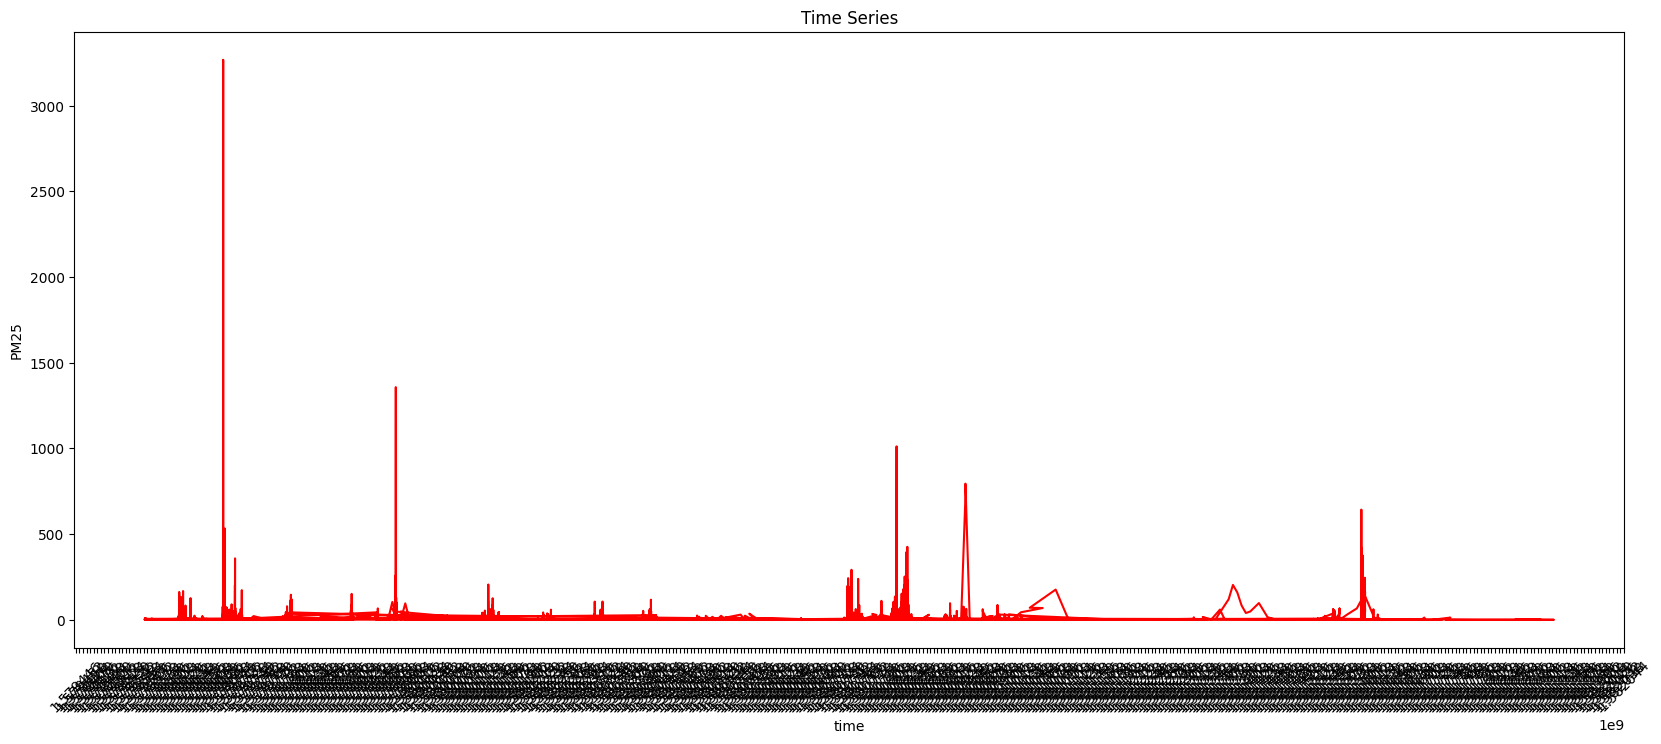

In [13]:
#Block 8
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(pmdata["time"], pmdata["pm25"], 'r')
ax.set(xlabel="time",
       ylabel="PM25",
       title="Time Series")
tick_spacing = 6000
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=45);
plt.show()


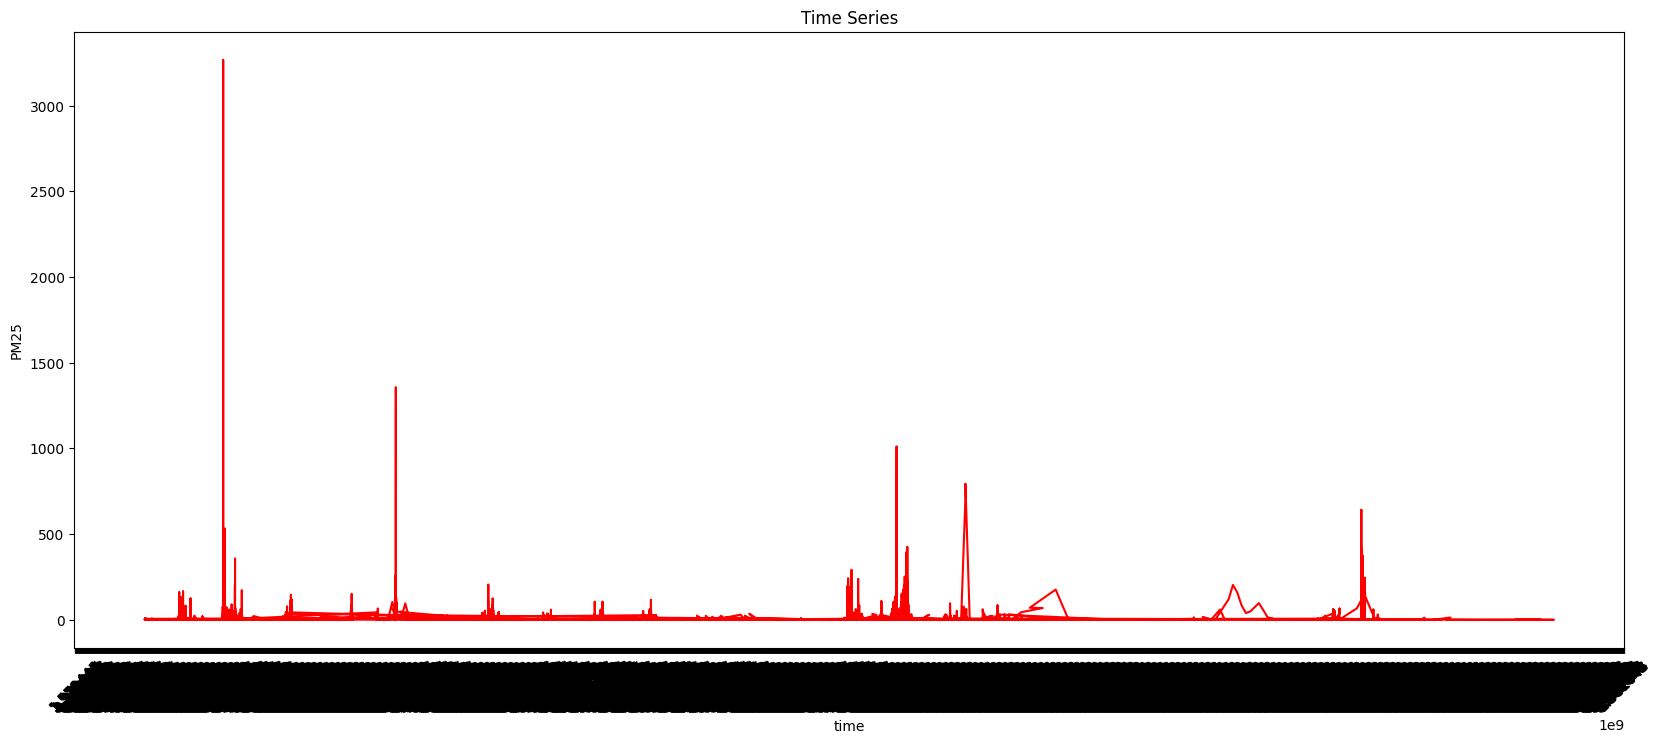

In [14]:
#Block 9
#this is a helpful image, but what if we just want to know the time series for one week, or another period of time?
#we can select the time we want to create a time series for using the code below.


fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(pmdata["time"], pmdata["pm25"], 'r')

ax.set(xlabel="time",
       ylabel="PM25",
       title="Time Series"
       ) #set the time range you are interested in using in the square brackets!
tick_spacing = 500                                                     #play with this number to increase or decrease the number of x axis labels
ax.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
plt.xticks(rotation=45);
plt.show()

#you can modify the pm and no2 files using a similar structure as above!

Great - now replace the temperature parameters with humidity, and even pm2.5 or no2 from the other data files. Rerun the code and see what you get! What does the data tell you?

## Part 2 - Mapping + Hotspot Analysis

Now that we created some time series graphs, we will work on creating maps. Let's start with a PM2.5 map!

In [15]:
pmdata.shape[0]

118765

In [16]:
pmdata_sample=pmdata.sample(frac=0.1)

In [17]:
pmdata_sample.shape[0]

11876

In [18]:
pmdata_sample.dtypes

SensorID        object
time             int64
latitude       float64
longitude      float64
bin0             int64
bin1             int64
bin2             int64
bin3             int64
bin4             int64
bin5             int64
bin6             int64
bin7             int64
bin8             int64
bin9             int64
bin10            int64
bin11            int64
bin12          float64
bin13          float64
bin14          float64
bin15          float64
bin16          float64
bin17          float64
bin18          float64
bin19          float64
bin20          float64
bin21          float64
bin22          float64
bin23          float64
temperature    float64
humidity       float64
pm1            float64
pm25           float64
pm10           float64
dtype: object

In [19]:
#Block 10
#we're going to make a map. we start by setting a center point for the map to display the data
coords = pmdata.loc[:,['latitude','longitude']].values #lat and lon are collected from CityScanner GPS
start_point=coords[0]

In [20]:
pmdata_sample.iloc[5]['pm25']

0.23

In [21]:
'''for i,row in pmdata_sample.iterrows():
  print(pmdata_sample.loc[i]["pm25"])'''

'for i,row in pmdata_sample.iterrows():\n  print(pmdata_sample.loc[i]["pm25"])'

In [22]:
#Block 11
#here, we set up the specifications for the map
newmap = folium.Map(location= start_point, tiles='Stamen Terrain', zoom_start=14)
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow'], vmin=0, vmax=21)
colormap.caption = 'PM 2.5 (ug/m^3)' #change this to represent the variable of interest!
colormap.add_to(newmap)


#this will loop through the data and show us where it's coming from
#each point on the map will display the PM2.5 value from that spot, in micrograms per cubic meter.
for i,row in pmdata_sample.iterrows():
    #folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color='blue', fill_color='blue', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)
    folium.CircleMarker((row.latitude,row.longitude), radius=4, weight=1, color=colormap(pmdata_sample.loc[i]['pm25']), fill ='true', fill_opacity=.5, popup=(row.pm25)).add_to(newmap)

newmap.add_child(colormap)
#here we save an html version of the map - you can zoom in and out of it and interact with it!
#this .html file will be saved to your google drive folder. Download it to your computer and open it to interact with it!
newmap.save('newmap.html')
#you may need to refresh the page on your google drive folder to see the updated map!
#you may also need to close a few tabs so you don't run out of memory when opening the map :)


#note - you can also create a map for a subset of the total deployment time by calling the "thdatamod", "pmdatamod", or "no2datamod" variable above!

Now that we have our point map, showing us where pm2.5 values and potential hotspot locations are, let's do some clustering. This will allow us to see where multiple measurements exceed the threshold value, potentially indicating a local source of pollution or pollution transport.

In [23]:
newmap

Output hidden; open in https://colab.research.google.com to view.

In [24]:
#Block 12
#let's start by setting 10 as the threshold value. Change this and see how the number of hotspots changes!
pmdata = pmdata.loc[(pmdata['pm25'] > 10)]

In [25]:
pmdata.shape[0]

21612

In [26]:
#Block 13
#hierarchical clustering code

# bottom-up hierarchical clustering - agglomerative, not k-means, because number of clusters not defined before
hotspots = pmdata
coords = hotspots.loc[:,['latitude','longitude']].values

#preprocessing for hotspot clustering
#we have to convert to radians, because scikit-learn’s haversine metric needs radian units
kms_per_radian = 6371.0088

#epsilon is the max distance points can be from each other to count as a cluster
epsilon = 0.1 / kms_per_radian

#min_samples is the minimum cluster size for a hotspot to be formed, and here we also call the haversine metric
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))-(1 if -1 in set(cluster_labels) else 0)
outliers = coords[cluster_labels == -1]

#here is where we create the clusters after doing the background math above
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
outliers = coords[cluster_labels == -1]
print('Number of clusters: {}'.format(num_clusters))



Number of clusters: 41


# Part 3 - Extract Street Network and Perform Spatial Analysis

---



Now we need to extract the street network of NYC using the boundaries in the nyc_polygon.geojson file which will ensure that the analysis is confined to the area of interest only.

In [30]:
#loading the nyc_polygon.geojson file
nyc_polygon = gpd.read_file('/content/drive/MyDrive/Foundations_of_data_Science/spring2324/ProjectData/nyc_polygon.geojson')

# making sure that the CRS is correct (coordinate reference system)
nyc_polygon = nyc_polygon.to_crs('EPSG:4326')

#extracting the street network for walking
G = ox.graph_from_polygon(nyc_polygon.geometry.unary_union, network_type='walk')
#this code took 12m 38s to run :) becareful

# part 4 - Performing spatial join

We need to convert the air quality data to a Geodataframe and do a spatial join with the street network. This step will link each air quality measurement with the nearest street segment

In [34]:
gdf_pm = gpd.GeoDataFrame(
    pmdata, geometry=gpd.points_from_xy(pmdata.longitude, pmdata.latitude),
    crs='EPSG:4326'
)


#converting to Geodataframe
nodes, edges = ox.graph_to_gdfs(G)

# the spatial join (linking each air quality measurement with the nearest street segment)
joined_data = gpd.sjoin_nearest(gdf_pm, edges, how="left")


/usr/local/lib/python3.10/dist-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting a warning here:
UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn

this warning is probably because we are using sjoin_nearest which involves calculating distances between air quality measurements and street segments and when geometries are in CRS 4326 distances are calculated on a sphere which can lead to innacuracies for certain spatial operations, especially for large distances.

# Part 5 - Route optimization


# part 6 - Advanced analysis (linear weighting method)

# Part 7 - Implementing an interactive map

##Summary
Now that you have finished going through this notebook, you should be able to create time series graphs, basic maps, and perform clustering analysis techniques on hyperlocal environmental data. Additionally, you should have a basic knowledge of some of the different pollutants that can be measured to tell us more about the quality of our immediate environment.



##Resources and references
Below you can find links to some of the CityScanner papers, some of the reference materials shown in the presentation, and some reference documentation for some of the python libraries!

CityScanner Papers:
*   [Challenges of Drive-By IoT Sensing for Smart Cities: City Scanner Case Study](https://senseable.mit.edu/papers/pdf/20181012_Anjomshooa-etal_ChallengesDrive-by_Purba.pdf)
*  [ City Scanner: Building and Scheduling a Mobile
Sensing Platform for Smart City Services](https://senseable.mit.edu/papers/pdf/20180522_Anjomshoaa-etal_CityScanner_IEEE-IoT.pdf)
* [Air quality monitoring using mobile low-cost sensors mounted on trashtrucks: Methods development and lessons learned](https://senseable.mit.edu/papers/pdf/20200601_deSouza-etal_AirQuality_SCS.pdf)



Python Library Documentation:
*  [Folium](http://python-visualization.github.io/folium/)
*  [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)


